# <center> Détectez des Faux Billets </center>

<div>
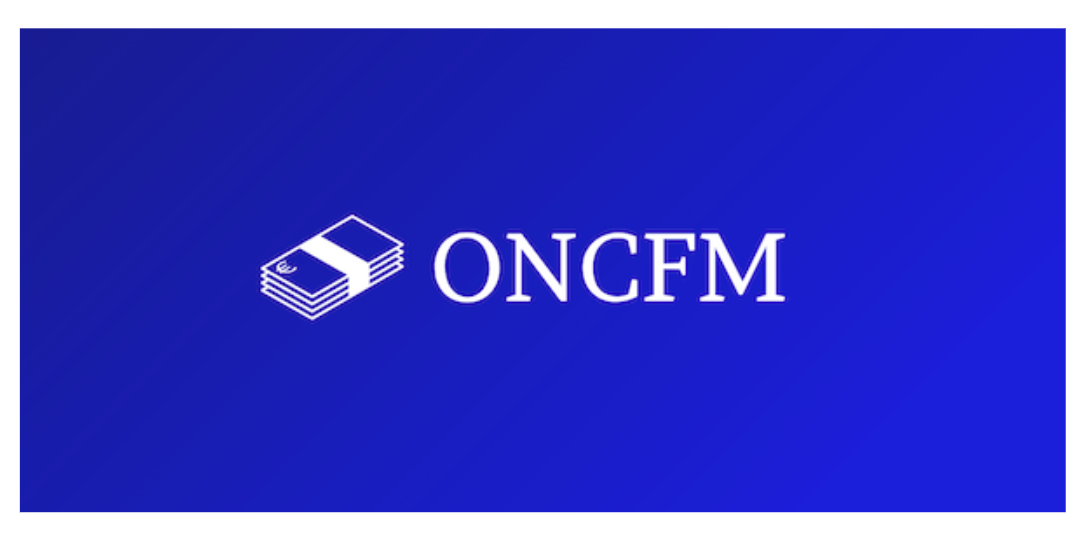
    </div>

Dans ce projet, il faut décrire des billets vrais et faux. Ensuite, le but est d'entrer un algorithme de régression logistique pour déterminer si un billet est vrai ou faux. 

Je vais d'abord importer, observer et décrire les données. Ensuite, j'utiliserai le clustering et la régression logistique pour trouver la différence entre les vrais et les faux billets, et finalement proposer un algorithme qui sera capable de différencier automatiquement les vrais des faux billets.

# I. Les données

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '1'
import warnings

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import t, shapiro

import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
os.chdir("C:/Users/majai/Dropbox/DATA ANALYST formation/Project 10/Livrables")

In [3]:
sns.set()
warnings.filterwarnings('ignore')

In [4]:
notes = pd.read_csv('billets.csv')
notes.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.46       103.36        103.66        3.77       2.99   
2        True    172.69       104.48        103.50        4.40       2.94   
3        True    171.36       103.91        103.94        3.62       3.01   
4        True    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54

In [5]:
notes.shape

(1500, 7)

In [6]:
notes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [7]:
notes.nunique()

is_genuine        2
diagonal        159
height_left     155
height_right    170
margin_low      285
margin_up       123
length          336
dtype: int64

In [8]:
notes.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [9]:
notes.duplicated().sum()

0

In [10]:
notes.describe().T

count        mean       std     min      25%     50%     75%  \
diagonal      1500.0  171.958440  0.305195  171.04  171.750  171.96  172.17   
height_left   1500.0  104.029533  0.299462  103.14  103.820  104.04  104.23   
height_right  1500.0  103.920307  0.325627  102.82  103.710  103.92  104.15   
margin_low    1463.0    4.485967  0.663813    2.98    4.015    4.31    4.87   
margin_up     1500.0    3.151473  0.231813    2.27    2.990    3.14    3.31   
length        1500.0  112.678500  0.872730  109.49  112.030  112.96  113.34   

                 max  
diagonal      173.01  
height_left   104.88  
height_right  104.95  
margin_low      6.90  
margin_up       3.91  
length        114.44

In [11]:
notes['is_genuine'].value_counts()

True     1000
False     500
Name: is_genuine, dtype: int64

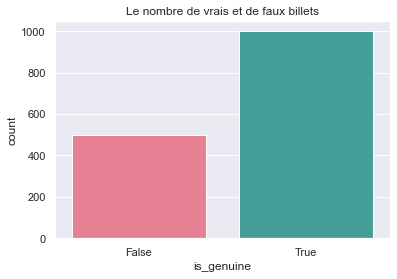

In [12]:
sns.countplot(x='is_genuine', data=notes, palette="husl")
plt.title("Le nombre de vrais et de faux billets")
plt.show()

In [13]:
notes.groupby('is_genuine').mean().T

is_genuine         False        True
diagonal      171.901160  171.987080
height_left   104.190340  103.949130
height_right  104.143620  103.808650
margin_low      5.215935    4.116097
margin_up       3.350160    3.052130
length        111.630640  113.202430

Les données contiennent 1500 observations, avec 6 variables quantitatives qui décrivent les dimensions des billets et une variable qualitative qui indique si le billet est vrai ou faux. Il y a 1000 vrais et 500 faux billets.

Il y a 37 valeurs manquantes dans la variable *margin_low*. Je remplirai les valeurs manquantes à l'aide d'un modèle de régression linéaire.

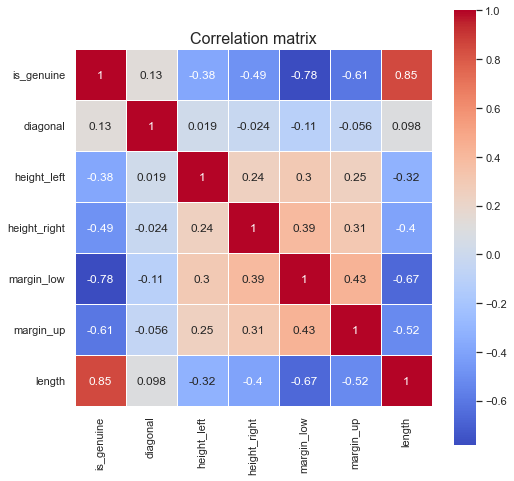

In [14]:
corrMatrix = notes.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corrMatrix, square=True, annot=True, linewidths=.5, cmap='coolwarm')
plt.title("Correlation matrix", fontsize=16)
plt.show()

Il existe une forte corrélation positive entre les variables *is_genuine* et *length*, et une forte corrélation négative entre *is_genuine* et *margin_low*.

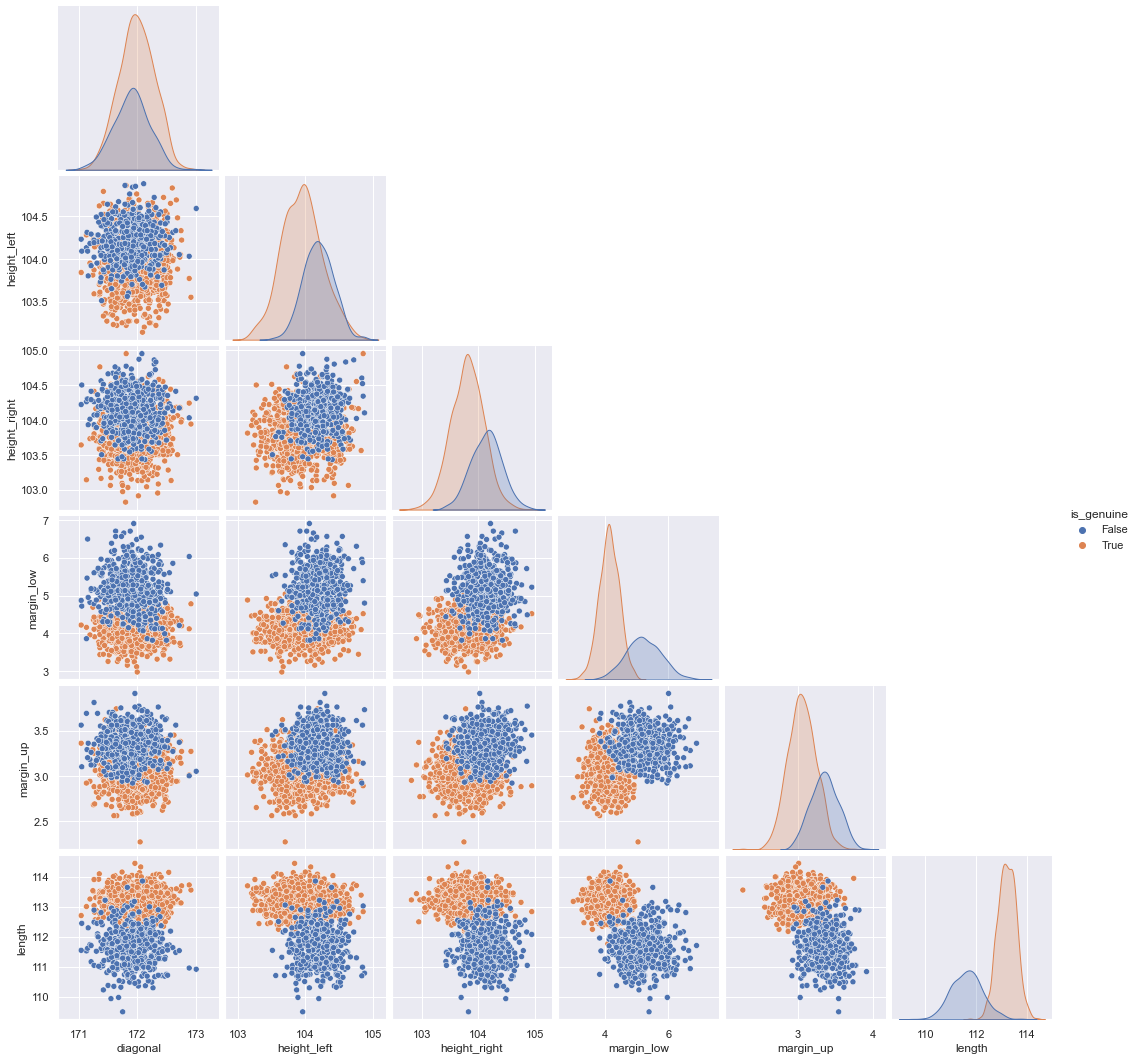

In [15]:
sns.pairplot(notes, hue='is_genuine', corner=True)
plt.show()

### Régression linéaire pour margin_low pour remplacer les valeurs manquantes par ses valeurs prédites

In [16]:
margins = notes[~notes["margin_low"].isnull()]

In [17]:
margins.describe().T

count        mean       std     min      25%     50%      75%  \
diagonal      1463.0  171.959193  0.305457  171.04  171.750  171.96  172.170   
height_left   1463.0  104.031333  0.299605  103.14  103.825  104.04  104.230   
height_right  1463.0  103.921476  0.324181  102.91  103.710  103.92  104.150   
margin_low    1463.0    4.485967  0.663813    2.98    4.015    4.31    4.870   
margin_up     1463.0    3.153083  0.231466    2.27    2.990    3.14    3.315   
length        1463.0  112.674757  0.873222  109.49  112.020  112.96  113.340   

                 max  
diagonal      173.01  
height_left   104.88  
height_right  104.95  
margin_low      6.90  
margin_up       3.91  
length        114.32

In [18]:
margins = margins.reset_index()
margins.tail()

index  is_genuine  diagonal  height_left  height_right  margin_low  \
1458   1495       False    171.75       104.38        104.17        4.42   
1459   1496       False    172.19       104.63        104.44        5.27   
1460   1497       False    171.80       104.01        104.12        5.51   
1461   1498       False    172.06       104.28        104.06        5.17   
1462   1499       False    171.47       104.15        103.82        4.63   

      margin_up  length  
1458       3.09  111.28  
1459       3.37  110.97  
1460       3.36  111.95  
1461       3.46  112.25  
1462       3.37  112.07

In [19]:
import statsmodels.formula.api as smf
reg_multi = smf.ols('margin_low~diagonal+height_left+height_right+margin_up+length', data=margins).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Wed, 14 Sep 2022   Prob (F-statistic):          2.60e-202
Time:                        10:25:52   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382   

#### Vérifier la colinéarité des variables:

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = reg_multi.model.exog
variable = ['diagonal', 'height_left', 'height_right', 'margin_up', 'length']
vif = [variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

In [21]:
pd.DataFrame([variable, vif]).T.rename(columns={0:'variable', 1:'vif'})

variable       vif
0      diagonal  1.013613
1   height_left  1.138261
2  height_right  1.230115
3     margin_up  1.404404
4        length   1.57695

Ici, tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

#### Testez l’homoscédasticité (la constance de la variance) des résidus:

In [22]:
import statsmodels
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 7.759535216211283e-16


La p-valeur ici n'est pas inférieure à $5$%, on ne rejette pas l'hypothèse $H0$ selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité).

#### Testez la normalité des résidus:

Si l'on veut tester la normalité des résidus, on peut faire un test de Shapiro-Wilk.

In [23]:
shapiro(reg_multi.resid)

ShapiroResult(statistic=0.9857879281044006, pvalue=8.536943374437556e-11)

Ici, l'hypothèse de normalité est remise en cause (p-value < 0.05).

**Final model to use to predict *margin_low*:**

$$margin\_low = 22.99-0.11\times diagonal+0.18\times height\_left+0.26\times height\_right+0.26\times margin\_up-0.41\times length$$

In [24]:
data = notes

In [25]:
to_predict = data[data["margin_low"].isnull()][['diagonal', 'height_left', 'height_right', 'margin_up', 'length']]

In [26]:
prediction = reg_multi.predict(to_predict)

In [27]:
data["margin_low"] = data["margin_low"].fillna(prediction)

In [28]:
data.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [29]:
data.describe().T

count        mean       std     min     25%     50%     75%  \
diagonal      1500.0  171.958440  0.305195  171.04  171.75  171.96  172.17   
height_left   1500.0  104.029533  0.299462  103.14  103.82  104.04  104.23   
height_right  1500.0  103.920307  0.325627  102.82  103.71  103.92  104.15   
margin_low    1500.0    4.483475  0.659632    2.98    4.02    4.31    4.87   
margin_up     1500.0    3.151473  0.231813    2.27    2.99    3.14    3.31   
length        1500.0  112.678500  0.872730  109.49  112.03  112.96  113.34   

                 max  
diagonal      173.01  
height_left   104.88  
height_right  104.95  
margin_low      6.90  
margin_up       3.91  
length        114.44

In [30]:
data.groupby('is_genuine').mean().T

is_genuine         False        True
diagonal      171.901160  171.987080
height_left   104.190340  103.949130
height_right  104.143620  103.808650
margin_low      5.214079    4.118174
margin_up       3.350160    3.052130
length        111.630640  113.202430

In [31]:
import scipy.stats as st
from scipy.stats import ks_2samp

def distrib_normalize(i):
  """Fonction qui trace la distribution d'une variable et qui calcule la symétrie, 
  le coefficient d'applatissement et le respect à une loi statistique : ici la loi normale
  Entrée : 
  - Colonne d'une variable

  Sortie : 
  - Graphique de distribution
  - Résultat de la symétrie
  - Résultat du coefficient d'applatissement
  - Résultat à l'adéquation à la loi normale
  """
  print(i.capitalize())
  _ = sns.displot(data[i])
  _ = plt.axvline(x=data[i].mean(), label='Moyenne', linestyle='-', color='r', linewidth=2)
  _ = plt.axvline(x=data[i].median(), label='Médiane', linestyle='--', color='b', linewidth=2)
  _ = plt.show()
  print('Skewness: ', str(st.stats.skew(data[i])))
  print('Kurtosis: ', str(st.stats.kurtosis(data[i])))
  print(str(ks_2samp(data[i],list(np.random.normal(np.mean(data[i]), np.std(data[i]), 1000)))))
  print('.')

Diagonal


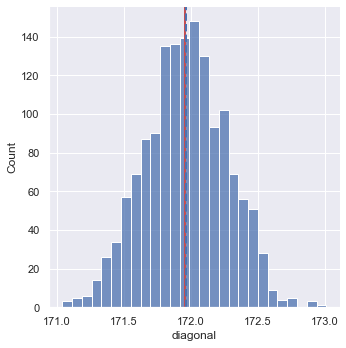

Skewness:  -0.03327338562637491
Kurtosis:  -0.1288643638667306
KstestResult(statistic=0.026333333333333334, pvalue=0.7925209664762456)
.
Height_left


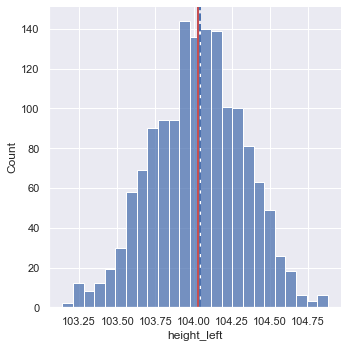

Skewness:  -0.09202848000665637
Kurtosis:  -0.19861842156870724
KstestResult(statistic=0.043333333333333335, pvalue=0.20568530229215332)
.
Height_right


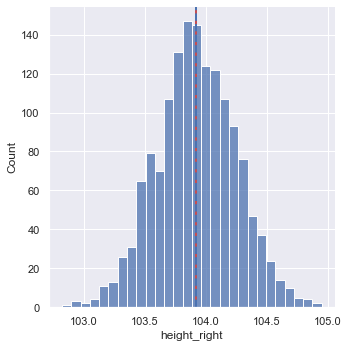

Skewness:  -0.000327219556341104
Kurtosis:  -0.031138318138161925
KstestResult(statistic=0.07466666666666667, pvalue=0.0023920625561193454)
.
Margin_low


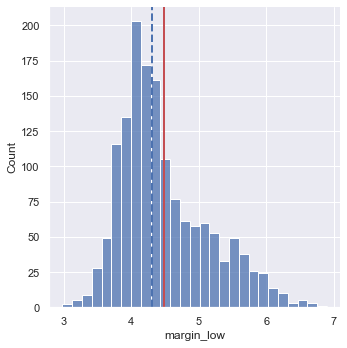

Skewness:  0.8697706246226017
Kurtosis:  0.24991754017065704
KstestResult(statistic=0.12666666666666668, pvalue=7.837975157798382e-09)
.
Margin_up


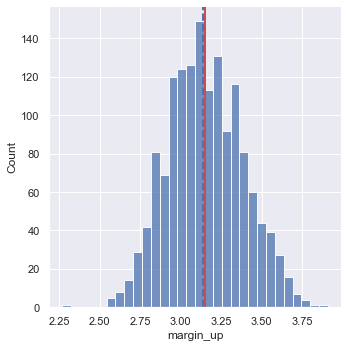

Skewness:  0.1457918478253625
Kurtosis:  -0.248256984444303
KstestResult(statistic=0.05, pvalue=0.09724933116732903)
.
Length


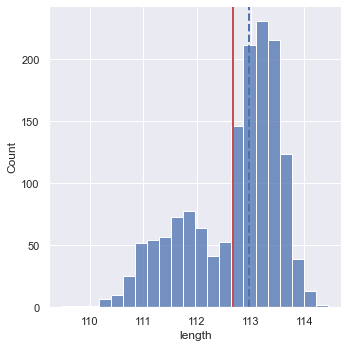

Skewness:  -0.8151403548537486
Kurtosis:  -0.28338839609225497
KstestResult(statistic=0.16166666666666665, pvalue=3.952393967665557e-14)
.


In [32]:
cols = data[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']]

for i in cols:
    distrib_normalize(i)

Les variables *margin_low* et *length* ne sont pas distribuées normalement (confirmé par le KS-test, p-value<0,05). Comme nous avons pu le voir dans la matrice de corrélation, *margin_low* et *length* sont fortement corrélés avec *is_genuine*, donc ces variables ont une grande influence sur le fait qu'un billet soit vrai ou faux.

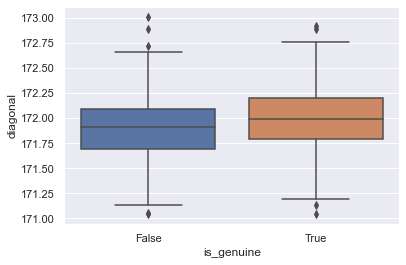

ANOVA:
                sum_sq      df          F        PR(>F)
is_genuine    2.460749     1.0  26.874763  2.466867e-07
Residual    137.162201  1498.0        NaN           NaN
__________________________________________________________


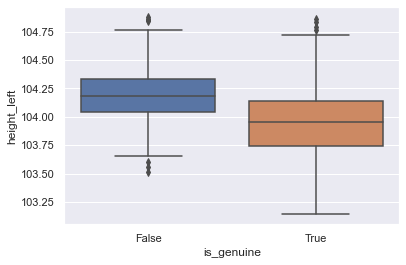

ANOVA:
                sum_sq      df           F        PR(>F)
is_genuine   19.394088     1.0  252.558393  1.126916e-52
Residual    115.032185  1498.0         NaN           NaN
__________________________________________________________


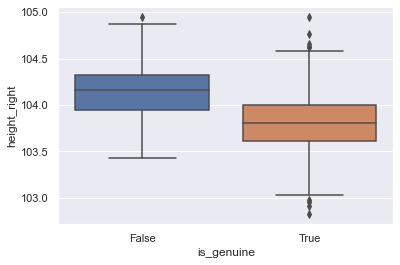

ANOVA:
                sum_sq      df           F        PR(>F)
is_genuine   37.401634     1.0  460.974212  2.270856e-89
Residual    121.541825  1498.0         NaN           NaN
__________________________________________________________


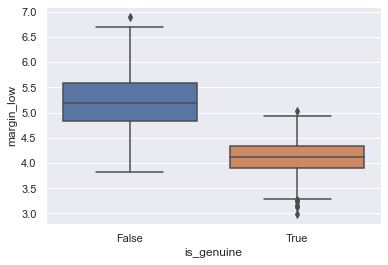

ANOVA:
                sum_sq      df            F         PR(>F)
is_genuine  400.336183     1.0  2380.723271  8.919896e-312
Residual    251.899752  1498.0          NaN            NaN
__________________________________________________________


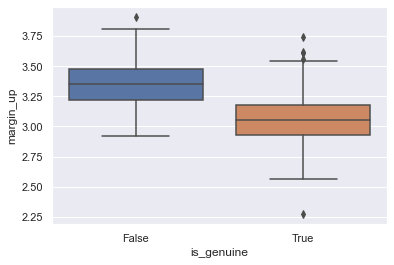

ANOVA:
               sum_sq      df           F         PR(>F)
is_genuine  29.607294     1.0  870.581394  3.144530e-151
Residual    50.944950  1498.0         NaN            NaN
__________________________________________________________


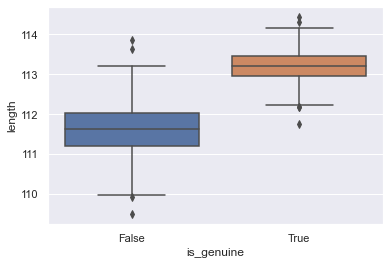

ANOVA:
                sum_sq      df            F  PR(>F)
is_genuine  823.507935     1.0  3876.654138     0.0
Residual    318.216390  1498.0          NaN     NaN
__________________________________________________________


In [33]:
import statsmodels.api as sm

for i in cols: 
    sns.boxplot(x='is_genuine', y=i, data=data)
    plt.show()
    
    response = data[i].name
    formula = "{} ~ is_genuine + 1".format(response,' + ')
    #print(formula)
    anova_notes = smf.ols(formula, data).fit()
    print('ANOVA:')
    print(sm.stats.anova_lm(anova_notes, typ=2))
    print('__________________________________________________________')
    

Les boîtes à moustaches ci-dessus montrent la distribution des variables en fonction de la variable *is_genuine*. L'ANOVA confirme qu'il existe une différence significative entre les deux groupes (vrais et faux billets) pour toutes les variables.

# II. Clustering

In [34]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [35]:
# Définir les fonctions pour afficher les cercles de corrélation, les plans factoriels et le tracé d'éboulis.
from sklearn import decomposition

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: 
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='12', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='6', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

In [36]:
df = data.drop(columns={'is_genuine'})

In [37]:
n_comp = 6
data_pca = df
# préparation des données pour l'ACP
X = data_pca.values
names = data_pca.index
features = data_pca.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(n_components=6)

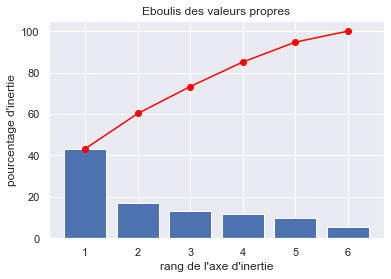

In [38]:
# Eboulis des valeurs propres
display_scree_plot(pca)

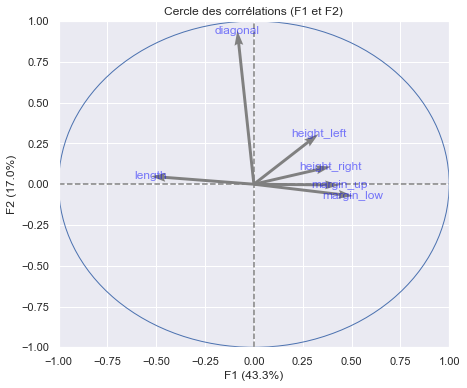

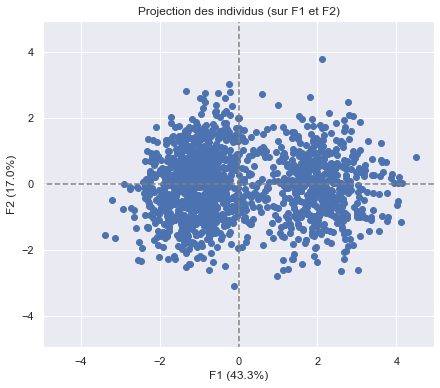

In [39]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)])

plt.show()

In [40]:
from sklearn.decomposition import PCA

def display_factorial_planes_color(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
  """Fonction qui trace la représentation des individus sur les plans factoriels
  Entrées :
  - Individus projetés
  - Nombre de composante
  - Fonction de l'ACP issue de Sklearn
  - Composantes que l'on souhaite représenter
  - Variables illustratives

  Sortie : 
  - Projection des individus sur les composantes sélectionnées
  """
  for d1,d2 in axis_ranks:
    if d2 < n_comp:
      # initialisation de la figure       
      fig = plt.figure(figsize=(7,6))
        
      # affichage des points
      if illustrative_var is None:
        plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
      else:
        illustrative_var = np.array(illustrative_var)
      for value in np.unique(illustrative_var):
        selected = np.where(illustrative_var == value)
        plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
      plt.legend()

      # affichage des labels des points
      if labels is not None:
        for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
          plt.text(x, y, labels[i],
          fontsize='14', ha='center',va='center') 
         
     # détermination des limites du graphique
      boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
      plt.xlim([-boundary,boundary])
      plt.ylim([-boundary,boundary])
        
      # affichage des lignes horizontales et verticales
      plt.plot([-100, 100], [0, 0], color='grey', ls='--')
      plt.plot([0, 0], [-100, 100], color='grey', ls='--')

      # nom des axes, avec le pourcentage d'inertie expliqué
      plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
      plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

      plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
      plt.show(block=False)

In [41]:
print(df.shape)
n = df.shape[0]
p = df.shape[1]

(1500, 6)


In [42]:
sc = StandardScaler()
Z = sc.fit_transform(df)
acp = PCA()
coord = acp.fit_transform(Z)

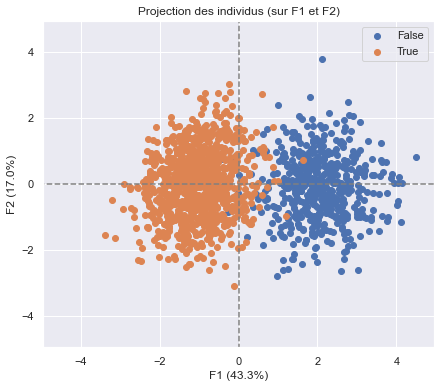

In [43]:
display_factorial_planes_color(coord, p, acp, [(0,1)], illustrative_var=data['is_genuine'])

### K-means

In [44]:
X = np.array(df)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca.n_components = 2
X_reduced = pca.fit_transform(X_scaled)
df_X_reduced = pd.DataFrame(X_reduced, index=df.index)

In [45]:
# Let the number of clusters be a parameter, so we can get a feel for an appropriate value thereof.
from sklearn.cluster import KMeans
from plotly.offline import iplot
import plotly.graph_objs as pgo
import plotly.graph_objects as go


def cluster(n_clusters):
    kmeans = KMeans(
        random_state=666,
        n_clusters=n_clusters)
    kmeans.fit(X_reduced)
    Z = kmeans.predict(X_reduced)
    return kmeans, Z

#max_clusters = len(df)
max_clusters = 25
inertias = np.zeros(max_clusters)

for i in range(1, max_clusters):
    kmeans, Z = cluster(i)
    inertias[i] = kmeans.inertia_
    
data1 = pgo.Scatter(
            x=np.arange(1, max_clusters),
            y=inertias[1:])

layout1 = pgo.Layout(title='Étudier k-means clustering',
                     xaxis=pgo.layout.XAxis(title='Nombre de clusters',
                     range=[0, max_clusters]),
                     yaxis=pgo.layout.YAxis(title='Inertia'))

fig1 = pgo.Figure(data=data1, layout=layout1)
iplot(fig1, filename='clustering-inertias')

Comme attendu, la méthode du coude révèle le choix d'un nombre de clusters égal à deux.

In [46]:
n_clusters = 2
model, Z = cluster(n_clusters)

In [47]:
# Represent neighborhoods, adding cluster information under color.
trace0 = pgo.Scatter(x=df_X_reduced[0],
                     y=df_X_reduced[1],
                     text=df.index,
                     name='',
                     mode='markers',
                     marker=pgo.scatter.Marker(size=df["margin_low"],
                                       sizemode='diameter',
                                       sizeref=df['margin_low'].max()/50,
                                       opacity=0.5,
                                       color=Z),
                     showlegend=False
)
# Represent cluster centers.
trace1 = pgo.Scatter(x=model.cluster_centers_[:, 0],
                     y=model.cluster_centers_[:, 1],
                     name='',
                     mode='markers',
                     marker=pgo.scatter.Marker(symbol='x',
                                       size=12,
                                       color=np.arange(n_clusters)),
                     showlegend=False
)
data2 = ([trace0, trace1])
layout2 = pgo.Layout(title='(PCA)',
                     xaxis=pgo.layout.XAxis(showgrid=True,
                                     zeroline=True,
                                     showticklabels=True),
                     yaxis=pgo.layout.YAxis(showgrid=True,
                                     zeroline=True,
                                     showticklabels=True),
                     hovermode='closest',
)

layout2['title'] = 'ACP et k-means clustering avec 2 clusters (taille du cercle: margin_low)'
fig2 = pgo.Figure(data=data2, layout=layout2)
iplot(fig2, filename='cluster-map')

In [48]:
Z = pd.DataFrame(Z).set_index(names).rename(columns={0:"cluster"})
data = data.join(Z)
data["cluster"].value_counts()

1    997
0    503
Name: cluster, dtype: int64

In [49]:
data.sample(6)

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
931        True    171.83       104.01        103.92        4.35       3.08   
167        True    172.20       104.06        103.97        4.16       3.17   
693        True    172.00       104.32        104.26        4.53       3.04   
552        True    171.86       103.93        103.80        4.27       2.86   
15         True    171.73       103.92        103.74        4.43       2.78   
870        True    172.14       104.34        103.98        3.84       2.98   

     length  cluster  
931  112.47        1  
167  112.47        1  
693  112.93        1  
552  113.97        1  
15   112.98        1  
870  113.05        1

In [50]:
pd.crosstab(index=data['is_genuine'], columns=data['cluster'])

cluster       0    1
is_genuine          
False       488   12
True         15  985

In [51]:
from sklearn.metrics import classification_report, confusion_matrix

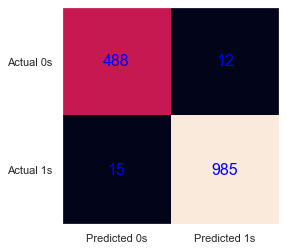

In [52]:
cm = confusion_matrix(data['is_genuine'], data['cluster'])

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='blue', fontsize=16)
plt.show()

In [53]:
print("Correct predictions by K-means:",np.round(100*((data["is_genuine"]==data["cluster"]).sum()/len(data)),2), "%.")

Correct predictions by K-means: 98.2 %.


In [54]:
data.groupby(['cluster']).mean().T

cluster                0           1
is_genuine      0.029821    0.987964
diagonal      171.899622  171.988114
height_left   104.202227  103.942407
height_right  104.155606  103.801595
margin_low      5.205706    4.119100
margin_up       3.350239    3.051194
length        111.650318  113.197232

In [55]:
data.groupby(['is_genuine']).mean().T

is_genuine         False        True
diagonal      171.901160  171.987080
height_left   104.190340  103.949130
height_right  104.143620  103.808650
margin_low      5.214079    4.118174
margin_up       3.350160    3.052130
length        111.630640  113.202430
cluster         0.024000    0.985000

# III. Logistic regression

In [56]:
from sklearn.linear_model import LogisticRegression

In [57]:
data.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.46       103.36        103.66        3.77       2.99   
2        True    172.69       104.48        103.50        4.40       2.94   
3        True    171.36       103.91        103.94        3.62       3.01   
4        True    171.73       104.28        103.46        4.04       3.48   

   length  cluster  
0  112.83        0  
1  113.09        1  
2  113.16        1  
3  113.51        1  
4  112.54        1

In [58]:
reg_log = smf.glm('is_genuine ~ diagonal+height_left+height_right+margin_low+margin_up+length', 
                  data=data, family=sm.families.Binomial()).fit()

print(reg_log.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1500
Model:                                                   GLM   Df Residuals:                     1493
Model Family:                                       Binomial   Df Model:                            6
Link Function:                                         logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -42.342
Date:                                       Wed, 14 Sep 2022   Deviance:                       84.685
Time:                                               10:26:13   Pearson chi2:                 2.65e+03
No. Iterations:                                           10                                         
Covariance Type:                                   nonrobust                      

In [59]:
reg_log = smf.glm('is_genuine ~ height_left+height_right+margin_low+margin_up+length', 
                  data=data, family=sm.families.Binomial()).fit()

print(reg_log.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1500
Model:                                                   GLM   Df Residuals:                     1494
Model Family:                                       Binomial   Df Model:                            5
Link Function:                                         logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -42.344
Date:                                       Wed, 14 Sep 2022   Deviance:                       84.689
Time:                                               10:26:13   Pearson chi2:                 2.66e+03
No. Iterations:                                           10                                         
Covariance Type:                                   nonrobust                      

In [60]:
reg_log = smf.glm('is_genuine ~ height_right+margin_low+margin_up+length', 
                  data=data, family=sm.families.Binomial()).fit()

print(reg_log.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1500
Model:                                                   GLM   Df Residuals:                     1495
Model Family:                                       Binomial   Df Model:                            4
Link Function:                                         logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -43.586
Date:                                       Wed, 14 Sep 2022   Deviance:                       87.173
Time:                                               10:26:14   Pearson chi2:                 3.24e+03
No. Iterations:                                           10                                         
Covariance Type:                                   nonrobust                      

**Modèle de probabilité de faux billet:**

<font size="3"> $$P(False) = e^{(323.45\, +\, 2.78\times height\_right\, +\, 6.02\times margin\_low \,+\, 10.21\times margin\_up \,-\, 5.98\times length)}$$ </font>


In [61]:
y = data["is_genuine"]
x = data[["height_right", "margin_low", "margin_up", "length"]]

In [62]:
data = data.join(pd.DataFrame(reg_log.predict(x)))

In [63]:
data = data.rename(columns={0:"probability"})
data.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.46       103.36        103.66        3.77       2.99   
2        True    172.69       104.48        103.50        4.40       2.94   
3        True    171.36       103.91        103.94        3.62       3.01   
4        True    171.73       104.28        103.46        4.04       3.48   

   length  cluster   probability  
0  112.83        0  6.016267e-02  
1  113.09        1  1.131599e-05  
2  113.16        1  1.269440e-04  
3  113.51        1  9.940759e-07  
4  112.54        1  1.162509e-01

In [64]:
data["prediction"] = 1
for i in range(len(data)):
    if data["probability"][i]>=0.5:
        data["prediction"][i] = 0

In [65]:
pd.crosstab(index=data['is_genuine'], columns=data['prediction'])

prediction    0    1
is_genuine          
False       492    8
True          3  997

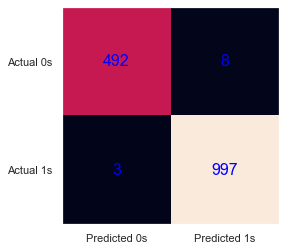

In [66]:
cm = confusion_matrix(data['is_genuine'], data['prediction'])

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='blue', fontsize=16)
plt.show()

In [67]:
print("Correct predictions by logistic regression:",np.round(100*((data["is_genuine"]==data["prediction"]).sum()/len(data)),2), "%.")

Correct predictions by logistic regression: 99.27 %.


In [68]:
data.sample(6)

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
687         True    172.02       104.23        104.26        4.92       2.89   
1011       False    172.09       104.44        104.24        4.90       3.13   
301         True    171.46       103.83        103.95        4.21       3.15   
1114       False    172.10       104.10        104.20        5.16       3.16   
1169       False    171.99       104.14        104.15        6.48       3.42   
1480       False    171.64       103.92        104.66        5.71       3.38   

      length  cluster  probability  prediction  
687   113.49        1     0.002004           1  
1011  111.93        0     0.995489           0  
301   113.59        1     0.000092           1  
1114  111.85        0     0.999517           0  
1169  112.16        0     1.000000           0  
1480  112.33        0     0.999991           0

La régression logistique a donné une prédiction plus précise que les K-means (99.27% contre 98.2%).

# IV. Model testing

In [69]:
os.getcwd()

'C:\\Users\\majai\\Dropbox\\DATA ANALYST formation\\Project 10\\Livrables'

In [70]:
exemple =  pd.read_csv('billets_production.csv')

In [71]:
exemple

diagonal  height_left  height_right  margin_low  margin_up  length   id
0    171.76       104.01        103.54        5.21       3.30  111.42  A_1
1    171.87       104.17        104.13        6.00       3.31  112.09  A_2
2    172.00       104.58        104.29        4.99       3.39  111.57  A_3
3    172.49       104.55        104.34        4.44       3.03  113.20  A_4
4    171.65       103.63        103.56        3.77       3.16  113.33  A_5

In [72]:
ex = exemple[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up','length']]
exemple = exemple.join(pd.DataFrame(reg_log.predict(ex)))

In [73]:
exemple = exemple.rename(columns={0:"probability"})

In [74]:
exemple["predicted"] = "True"
for i in range(len(exemple)):
    if exemple["probability"][i]>=0.5:
        exemple["predicted"][i]="False"

In [75]:
exemple.drop(["probability"], axis=1)

diagonal  height_left  height_right  margin_low  margin_up  length   id  \
0    171.76       104.01        103.54        5.21       3.30  111.42  A_1   
1    171.87       104.17        104.13        6.00       3.31  112.09  A_2   
2    172.00       104.58        104.29        4.99       3.39  111.57  A_3   
3    172.49       104.55        104.34        4.44       3.03  113.20  A_4   
4    171.65       103.63        103.56        3.77       3.16  113.33  A_5   

  predicted  
0     False  
1     False  
2     False  
3      True  
4      True

In [76]:
ex = exemple.drop(['id', 'probability', 'predicted'], axis=1)
ex = ex.append(data[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']])

In [77]:
n = ex.shape[0]
p = ex.shape[1]

sc = StandardScaler()
Z_ex = sc.fit_transform(ex)
acp = PCA()
coord = acp.fit_transform(Z_ex)

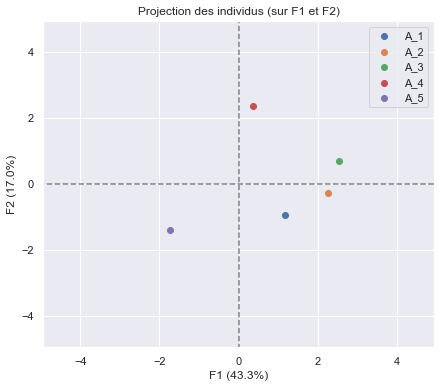

In [78]:
display_factorial_planes_color(coord, p, acp, [(0,1)], illustrative_var=exemple['id'])

# V. L'analyse complémentaire: t-SNE

In [79]:
from sklearn.manifold import TSNE
from numpy import reshape
import seaborn as sns
import pandas as pd 

In [80]:
x = data[['diagonal',  'height_left', 'height_right', 'margin_low', 'margin_up', 'length']]
y = data['is_genuine']

In [81]:
ex = exemple[['diagonal',  'height_left', 'height_right', 'margin_low', 'margin_up', 'length']] 

In [82]:
x = x.append(ex)

In [83]:
tsne = TSNE(n_components=2, verbose=1, random_state=666)
z = tsne.fit_transform(x)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1505 samples in 0.005s...
[t-SNE] Computed neighbors for 1505 samples in 0.096s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1505
[t-SNE] Computed conditional probabilities for sample 1505 / 1505
[t-SNE] Mean sigma: 0.247467
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.006889
[t-SNE] KL divergence after 1000 iterations: 1.347396


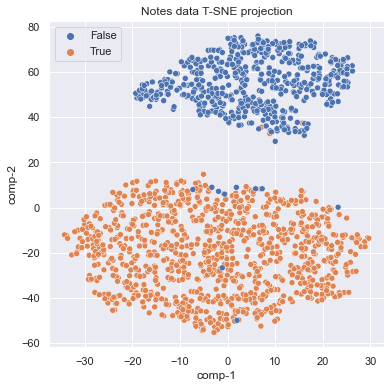

In [84]:
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[0:1500,0]
df["comp-2"] = z[0:1500,1]

fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x="comp-1", y="comp-2", 
                hue=df.y.tolist(),
                #palette=sns.color_palette("hls", 2),
                data=df).set(title="Notes data T-SNE projection") 
plt.show()

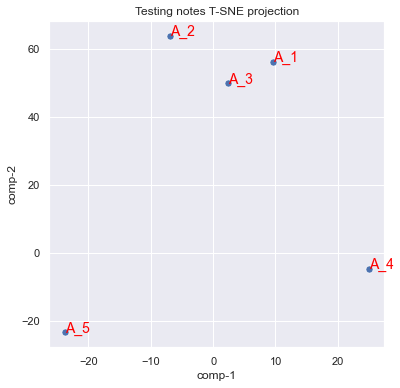

In [85]:
df = exemple[['id']]
df["comp-1"] = z[1500:1505,0]
df["comp-2"] = z[1500:1505,1]

fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x="comp-1", y="comp-2", 
                #palette=sns.color_palette("hls", 2),
                data=df, s=50).set(title="Testing notes T-SNE projection")
for i in range(df.shape[0]):
    plt.text(x=df['comp-1'][i],y=df['comp-2'][i],s=df.id[i], 
          fontdict=dict(color='red',size=14))
    
plt.show()
